## <center>KNN -  K Nearest Neighbors - Classification</center>

To understand KNN for classification, we'll work with a simple dataset representing gene expression levels. Gene expression levels are calculated by the ratio between the expression of the target gene (i.e., the gene of interest) and the expression of one or more reference genes (often household genes). This dataset is synthetic and specifically designed to show some of the strengths and limitations of using KNN for Classification.


More info on gene expression: https://www.sciencedirect.com/topics/biochemistry-genetics-and-molecular-biology/gene-expression-level


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('gene_expression.csv')
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


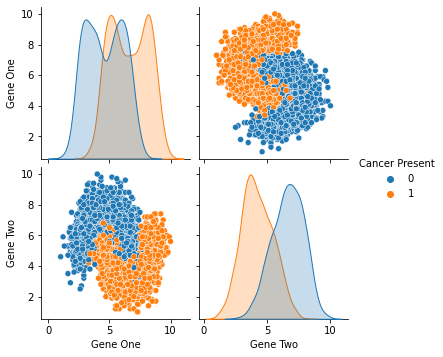

In [3]:
sns.pairplot(data=df, hue="Cancer Present")

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

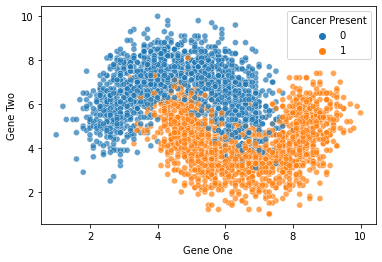

In [4]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df,alpha=0.7)

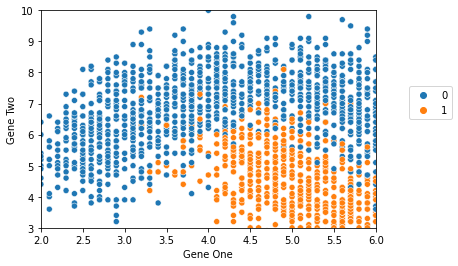

In [5]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',data=df)
plt.xlim(2,6)
plt.ylim(3,10)
plt.legend(loc=(1.1,0.5))

### Train Test Split and Scaling Data

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
X = df.drop('Cancer Present',axis=1)
y = df['Cancer Present']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
scaler = StandardScaler()  # Very important to always scale the data

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

### KNN

The KNN algorithm is arguably the simplest machine learning algorithm. Building the model consists only of storing the training dataset. To make a prediction for a new data point, the algorithm finds the closest data points in the training dataset—its “nearest neighbors.” In its simplest version, the k-NN algorithm only considers exactly one nearest neighbor, which is the closest training data point to the point we want to make  a prediction for.

In [9]:
from sklearn.neighbors import KNeighborsClassifier

In [10]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [11]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

#### Understanding KNN and Choosing K Value

In [12]:
scaled_X_test

array([[ 1.15402346, -0.73799913],
       [-0.1564804 , -1.49351629],
       [ 1.80927539, -0.67988242],
       ...,
       [ 1.4270451 ,  0.59868509],
       [ 1.15402346, -0.3892989 ],
       [-1.03014964,  1.8772526 ]])

In [13]:
full_test = pd.DataFrame(data=scaled_X_test, columns=["Gene One", "Gene Two"])
full_test["Cancer Present"] = y_test.values

In [14]:
full_test

,Gene One,Gene Two,Cancer Present
0,1.154023,-0.737999,1
1,-0.156480,-1.493516,1
2,1.809275,-0.679882,1
3,-1.248567,0.191868,0
4,-0.484106,1.121735,0
...,...,...,...
895,-0.320293,0.424335,1
896,-1.794610,-0.447416,0
897,1.427045,0.598685,1
898,1.154023,-0.389299,0


In [15]:
len(full_test)

900

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

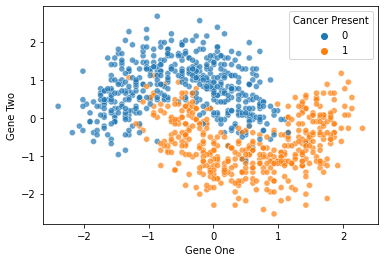

In [16]:
sns.scatterplot(x='Gene One',y='Gene Two',hue='Cancer Present',
                data=full_test,alpha=0.7)

#### Model Evaluation

In [17]:
y_pred = knn_model.predict(scaled_X_test)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [19]:
confusion_matrix(y_test,y_pred)

array([[426,  44],
       [ 45, 385]], dtype=int64)

In [20]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



### Elbow Method for Choosing Reasonable K Values

**NOTE: This uses the test set for the hyperparameter selection of K.**

In [21]:
test_error_rates = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 
   
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred_test)
    test_error_rates.append(test_error)

Text(0.5, 0, 'K Value')

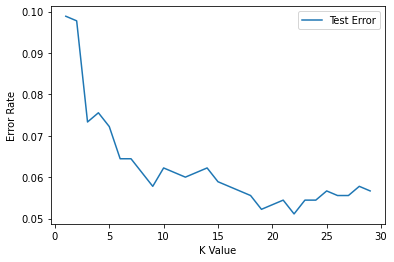

In [22]:
plt.plot(range(1,30),test_error_rates,label='Test Error')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel("K Value")

#### Score method

Another graphical method to determine the best neighbor is by plotting the scores of the train and test data, and their changes with the increase of neighbors. The k-point at which both are the closest is chosen to be the best number of neighbors

Text(0.5, 0, 'K Value')

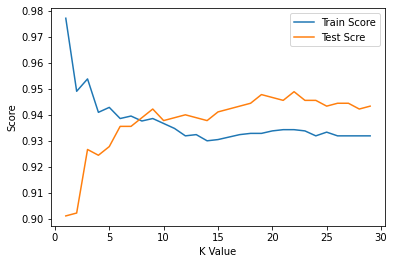

In [23]:
train_score = []
test_score = []


for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train) 

    train_score.append(knn_model.score(scaled_X_train, y_train))
    test_score.append(knn_model.score(scaled_X_test, y_test))
   
    
plt.plot(range(1,30),train_score,label='Train Score')
plt.plot(range(1,30),test_score,label='Test Scre')

plt.legend()
plt.ylabel('Score')
plt.xlabel("K Value")

In this case, where both graphs cross eachother, environ 7-8 neighbors, could be determined as the best number. This result is similar to the elbow curve, where the first minimum, before a rise, occurs in neighbors 7-8.

### Full Cross Validation Grid Search for K Value

#### Creating a Pipeline to find K value


We'll use a Pipeline object to set up a workflow of operations:

1. Scale Data
2. Create Model on Scaled Data

----
*How does the Scaler work inside a Pipeline with CV? Is scikit-learn "smart" enough to understand .fit() on train vs .transform() on train and test?**

**Yes! Scikit-Learn's pipeline is well suited for this! [Full Info in Documentation](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling) **

When you use the StandardScaler as a step inside a Pipeline then scikit-learn will internally do the job for you.

What happens can be discribed as follows:

* Step 0: The data are split into TRAINING data and TEST data according to the cv parameter that you specified in the GridSearchCV.
* Step 1: the scaler is fitted on the TRAINING data
* Step 2: the scaler transforms TRAINING data
* Step 3: the models are fitted/trained using the transformed TRAINING data
* Step 4: the scaler is used to transform the TEST data
* Step 5: the trained models predict using the transformed TEST data

----

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [25]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

In [26]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [27]:
# Highly recommend string code matches variable name!

operations = [('scaler',scaler), ('knn',knn)]

In [28]:
pipe = Pipeline(operations)

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

[StackOverflow on this](https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline)

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).

---

In [29]:
k_values = list(range(1,20))

In [30]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [31]:
param_grid = {'knn__n_neighbors': k_values}

In [32]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [33]:
# Use full X and y if you DON'T want a hold-out test set
# Use X_train and y_train if you DO want a holdout test set (X_test,y_test)
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [34]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [35]:
full_cv_classifier.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [36]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90380952, 0.90714286, 0.92142857, 0.91380952, 0.92380952,
       0.92047619, 0.92761905, 0.9252381 , 0.9247619 , 0.92285714,
       0.9252381 , 0.92428571, 0.92761905, 0.92809524, 0.92857143,
       0.93      , 0.92904762, 0.92857143, 0.92761905])

### Final Model

We just saw that our  GridSearch recommends a K=16 (in line with our alternative Elbow Method). Let's now use the PipeLine again, but this time, no need to do a grid search, instead we will evaluate on our hold-out Test Set.

In [37]:
scaler = StandardScaler()
knn16 = KNeighborsClassifier(n_neighbors=16)
operations = [('scaler',scaler),('knn16',knn16)]

In [38]:
pipe = Pipeline(operations)

In [39]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn16', KNeighborsClassifier(n_neighbors=16))])

In [40]:
pipe_pred = pipe.predict(X_test)

In [41]:
print(classification_report(y_test,pipe_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [42]:
new_patient = [[3.8, 6.4]]

print(pipe.predict(new_patient))
print(pipe.predict_proba(new_patient))

[0]
[[1. 0.]]


c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


###                                               k-neighbors regression
There is also a regression variant of the k-nearest neighbors algorithm. Where kNN = 1 means a perfect fit, and by increasing the k value, the accuracy in the regression decreases


In [43]:
from sklearn.neighbors import KNeighborsRegressor
import mglearn

In [44]:
X, y = mglearn.datasets.make_wave(n_samples=40)
# split the wave dataset into a training and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# instantiate the model and set the number of neighbors to consider to 3
reg = KNeighborsRegressor(n_neighbors=3)
# fit the model using the training data and training targets
reg.fit(X_train, y_train)

print("Test set predictions:\n{}".format(reg.predict(X_test)))
print("Test set R^2: {:.2f}".format(reg.score(X_test, y_test)))

Test set predictions:
[-0.05396539  0.35686046  1.13671923 -1.89415682 -1.13881398 -1.63113382
  0.35686046  0.91241374 -0.44680446 -1.13881398]
Test set R^2: 0.83


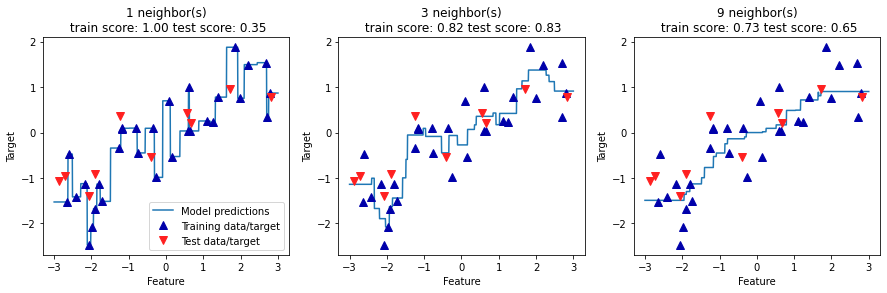

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# create 1,000 data points, evenly spaced between -3 and 3
line = np.linspace(-3, 3, 1000).reshape(-1, 1)
for n_neighbors, ax in zip([1, 3, 9], axes):
    # make predictions using 1, 3, or 9 neighbors
    reg = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    ax.plot(line, reg.predict(line))
    ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
    ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)
    ax.set_title(
        "{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, reg.score(X_train, y_train),
            reg.score(X_test, y_test)))
    ax.set_xlabel("Feature")
    ax.set_ylabel("Target")
axes[0].legend(["Model predictions", "Training data/target", "Test data/target"], loc="best")

plt.show()

As we can see from the plot, using only a single neighbor, each point in the training set has an obvious influence on the predictions, and the predicted values go through all of the data points. This leads to a very unsteady prediction. Considering more neighbors leads to smoother predictions, but these do not fit the training data as well.